# 01_ OpenCV를 이용한 문서 스캐너 구현

### 1. 함수 import하기

In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt 

### 2. 이미지 불러오기

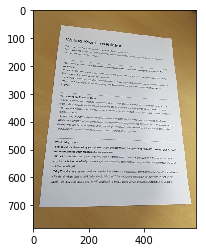

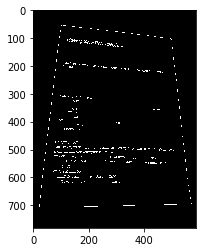

In [4]:
img = cv2.imread("img/paper.jpg")
# 이미지 grayscale 적용
image_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# GaussianBlur를 이용하여 경계값 흐릿하게 만들기
blur = cv2.GaussianBlur(image_gray, (5,5), 0)
# blur threshold를 이용하여 이진분류
ret, imthres = cv2.threshold(blur, 127, 255, cv2.THRESH_BINARY)
# 캐니엣지를 사용하여 경계 추출
edges = cv2.Canny(blur, 50, 260)
# cv2.imshow('Img', img)
# cv2.imshow('Edges', edges)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB))
plt.show()

### 3. Edges에서 Contour 꼭지점 좌표 뽑기
> findContours 함수 사용하여 전체 contours 꼭지점 좌표를 추출함
>image, contours, hierarchy = cv2.findContours(src, mode, method[, contours, hierarchy, offset])  

In [5]:
_, contours, hierarchy = cv2.findContours(edges,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
#findContours(이미지, 적용함수, 추출기법)
#cv2.RETR_EXTERNAL : 가장 바깥쪽 라인만 제공
#cv2.CHAIN_APPROX_SIMPLE : 컨투어 꼭지점 좌표만 추출
total = 0

> contour의 면적을 key값으로 내림차순을 하여 contours 추출

In [6]:
# contourArea를 기준으로 내림차순으로 4개의 contour를 뽑음
contours = sorted(contours, key = cv2.contourArea, reverse = True)[:4]

# epsilon 설정 후 contour 좌표를 4개 뽑아 screenCnt로 array 만들기
for c in contours:
    epsilon = 0.02 * cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, epsilon, True)
    
    if len(approx) == 4:
        break

> approx의 shape를 확인해보면 (4, 1, 2)임을 알 수 있음 **approx의 size를 변경**해야함

In [8]:
approx = np.resize(approx, (4, 2))  #(4, 2) size로 변경
approx = np.array(approx) # array로 정의
approx = approx.astype(np.float32)
print(approx)

[[101.  55.]
 [ 23. 706.]
 [568. 695.]
 [497. 103.]]


### 4. 원근법을 이용하여 이미지 확장

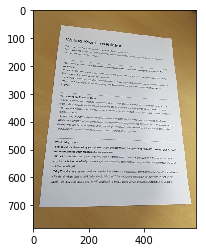

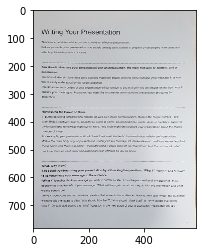

In [11]:
# edges의 row길이, col길이를 추출
image = edges.copy()
rows, cols = image.shape[:2]

# contour의 꼭지점 좌표를 pts1에 저장
pts1 = np.float32([approx[0], approx[1], approx[3], approx[2]])
# edges의 row길이, col길이를 이용하여 확장시킬 꼭지점 좌표 지정 후 pts2에 저장
pts2 = np.float32([[0,0], [0,rows], [cols, 0], [cols,rows]])

# getPerspectiveTransform 함수를 이용하여 pts1의 좌표를 pts2의 좌표로 대응시킴
mtrx = cv2.getPerspectiveTransform(pts1, pts2)

# 대응시킨 좌표를 img에 적용
dst = cv2.warpPerspective(img, mtrx, (cols, rows))

# cv2.imshow('Images', img)
# cv2.imshow('dst',dst)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))
plt.show()